# A Language Model using Financial Reporting Standards

This is a modified notebook taken from the FastAI Deep Learning course [Lesson 4](https://github.com/fastai/fastai/blob/master/courses/dl1/lesson4-imdb.ipynb) and [Lesson 6](https://github.com/fastai/fastai/blob/master/courses/dl1/lesson6-rnn.ipynb). This was an experiment to see whether a model from the FastAI library trained using Financial Reporting Standards (FRS) data can give coherent answers when prompted with accounting queries. The data used are the [Financial Reporting Standards (2018)](https://www.asc.gov.sg/frs2018volume). We will be trying out a word level and character level language model separately.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *
import html

import dill as dill
import spacy
import textract
from fastai.learner import *

import torchtext
from torchtext import vocab, data
from torchtext.datasets import language_modeling

from fastai.rnn_reg import *
from fastai.rnn_train import *
from fastai.nlp import *
from fastai.lm_rnn import *

path=Path('/home/lyk/Documents/FRS2018')
spacy_tok = spacy.load('en')
TEXT = data.Field(lower=True, tokenize="spacy")

/home/lyk/anaconda3/envs/fastai/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.22) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)


Conversion of FRS PDFs to text format using [Textract](https://github.com/deanmalmgren/textract).

In [30]:
# #convert pdf to text
# for fname in path.glob('*.pdf'):
#     new_fname = re.search('.{28}(.+).pdf',str(fname)).group(1)
#     with open(path/f'txt/{new_fname}.txt', 'w') as f:
#         f.write(re.sub('\n+',' ',textract.process(fname).decode('utf-8')))

### FRS Word Level Language Model

In [4]:
TEXT=data.Field(lower=True,tokenize='spacy')

bs=32 #batch-size
bptt=70 #bptt backprop-through-time: how many tokens to put in at once (i.e. 70)

FILES = dict(train=path/'txt/train', validation=path/'txt/val', test=path/'txt/val')
md = LanguageModelData.from_text_files(path, TEXT, **FILES, bs=bs, bptt=bptt, min_freq=10)

#dill.dump(TEXT, open(path/'TEXT.pkl','wb'))

len(md.trn_dl), md.nt, len(md.trn_ds), len(md.trn_ds[0].text)

(268, 2782, 1, 603442)

In [5]:
TEXT.vocab.itos[:12]

['<unk>', '<pad>', 'the', 'of', ',', '.', 'in', 'a', 'to', ')', 'and', '(']

In [6]:
em_sz = 200  # size of each embedding vector (50-600 is a good number)
nh = 500     # number of hidden activations per layer
nl = 3       # number of layers

In [7]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [8]:
learner = md.get_model(opt_fn, em_sz, nh, nl,
               dropouti=0.05, dropout=0.05, wdrop=0.1, dropoute=0.02, dropouth=0.05)
learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1) # to reduce overfitting
learner.clip=0.3 #don't let gradient(?) be more than 0.3

The method `lr_find()` is an implementaion by FastAI of the 2015 paper [Cyclical Learning Rates for Training Neural Networks](http://arxiv.org/abs/1506.01186) to find a good value to set the learning rate. Choosing a high enough learning rate where the validation loss is still improving will speed up training while maintaining model performance. From the chart, a learning rate of 1e-2 seems to be the most appropriate.

 95%|█████████▍| 254/268 [00:12<00:00, 19.97it/s, loss=19.7]

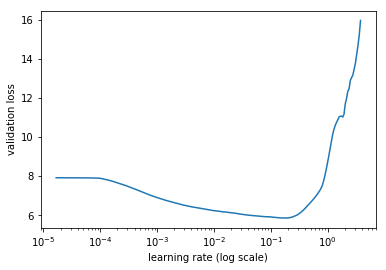

In [8]:
learner.lr_find()
learner.sched.plot()

- wds refers to weight decay (L2 Regularization)
- cycle_len refers to how long to gradually decrease the learning rate in one epoch (The FastAI Library uses cosine annealing)
- cycle_mult is how much to multiply the length of one epoch after the previous epoch finishes.

In [9]:
learner.fit(1e-2, 3, wds=1e-5, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                              
    0      5.851322   5.759224  
    1      5.859929   5.874969                              
    2      5.788686   5.720853                              
    3      4.803605   4.667127                              
    4      4.030635   4.132255                              
    5      3.749445   3.933609                              
    6      3.647808   3.871671                              


[array([3.87167])]

The model starts to overfit slightly after 3 epochs as the validation loss starts becoming greater than the training loss.

In [10]:
learner.save_encoder('adam3_enc')

In [9]:
learner.load_encoder('adam3_enc')

In [10]:
m=learner.model
sentence='a liability is'
s_tok = [spacy_tok(sentence)]
t=TEXT.numericalize(s_tok)

In [11]:
# Set batch size to 1
m[0].bs=1
# Turn off dropout
m.eval()
# Reset hidden state
m.reset()
# Get predictions from model
res,*_ = m(t)
# Put the batch size back to what it was
m[0].bs=bs

In [62]:
print(sentence,"\n")
for i in range(100):
    n=res[-1].topk(2)[1]
    n = n[1] if n.data[0]==0 else n[0]
    print(TEXT.vocab.itos[n.data[0]], end=' ')
    res,*_ = m(n[0].unsqueeze(0))
print('...')

a liability is 

( a ) the amount of the consideration received ( or receivable ) in the period in which the entity has a right to receive cash or another financial asset to the entity . ( b ) the entity has a right to receive cash or another financial asset to another entity . the entity ’s own equity instruments are not recognised in the entity ’s statement of financial position . the entity ’s share of the net assets of the entity ’s net assets of the entity and the entity ’s own equity instruments are not recognised in profit ...


The result of the query actually came out decently even though it is not entirely correct. When given more complex queries, the model does not perform as well and will tend to give less coherent answers as shown below.

In [10]:
m=learner.model
sentence='an intangible asset is measured at'
s_tok = [spacy_tok(sentence)]
t=TEXT.numericalize(s_tok)

In [11]:
# Set batch size to 1
m[0].bs=1
# Turn off dropout
m.eval()
# Reset hidden state
m.reset()
# Get predictions from model
res,*_ = m(t)
# Put the batch size back to what it was
m[0].bs=bs

In [13]:
print(sentence,"\n")
for i in range(100):
    n=res[-1].topk(2)[1]
    n = n[1] if n.data[0]==0 else n[0]
    print(TEXT.vocab.itos[n.data[0]], end=' ')
    res,*_ = m(n[0].unsqueeze(0))
print('...')

an intangible asset is measured at 

, the entity ’s own equity instruments , the entity shall disclose the following : ( a ) the entity ’s financial statements ( see paragraph 10 ) . ( b ) the entity ’s financial statements ( see paragraph 10 ) . ( b ) the entity ’s financial statements ( see paragraph 10 ) . ( b ) the entity ’s financial statements ( see paragraph 10 ) . ( b ) the entity ’s financial statements in accordance with frs 109 . the entity shall recognise the following : ( a ) the entity ’s financial statements ...


### FRS Character level Language Model

In [65]:
text_list=[]
for fname in (path/'txt').glob('*.txt'):
    text_list.append(open(fname).read())

text = [i for o in text_list for i in o]

print('corpus length:', len(text))

corpus length: 4475064


In [66]:
chars = sorted(list(set(text)))
vocab_size = len(chars)+1
print('total unique characters:', vocab_size)

total chars: 110


In [67]:
chars.insert(0, "\0")
''.join(chars[1:-6])

"\x0c $%&'()*+,-./0123456789:;=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[]^abcdefghijklmnopqrstuvwxyz{}\x80\x93\x99£¥±×â÷‒–—‘’“”"

In [68]:
char_indices = {c: i for i, c in enumerate(chars)}
indices_char = {i: c for i, c in enumerate(chars)}
idx = [char_indices[c] for c in text]

In [69]:
''.join(indices_char[i] for i in idx[:70])

'INTERPRETATION OF FINANCIAL REPORTING STANDARD INT FRS 114 FRS 19—The '

In [76]:
from fastai import sgdr

n_hidden=512

In [77]:
#Taken from the FastAI Deep Learning course Lesson 6 notebook
class CharSeqStatefulLSTM(nn.Module):
    def __init__(self, vocab_size, n_fac, bs, nl):
        super().__init__()
        self.vocab_size,self.nl = vocab_size,nl
        self.e = nn.Embedding(vocab_size, n_fac)
        self.rnn = nn.LSTM(n_fac, n_hidden, nl, dropout=0.5)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        self.init_hidden(bs)
        
    def forward(self, cs):
        bs = cs[0].size(0)
        if self.h[0].size(1) != bs: self.init_hidden(bs)
        outp,h = self.rnn(self.e(cs), self.h)
        self.h = repackage_var(h)
        return F.log_softmax(self.l_out(outp), dim=-1).view(-1, self.vocab_size)
    
    def init_hidden(self, bs): #for LSTM, need to return a tuple
        self.h = (V(torch.zeros(self.nl, bs, n_hidden)),
                  V(torch.zeros(self.nl, bs, n_hidden)))

In [78]:
m = CharSeqStatefulLSTM(md.nt, n_fac, 512, 2).cuda()
lo = LayerOptimizer(optim.Adam, m, 1e-2, 1e-5)

In [80]:
os.makedirs(f'{path}models', exist_ok=True)

In [81]:
fit(m, md, 2, lo.opt, F.nll_loss)

epoch      trn_loss   val_loss                                 
    0      1.065968   1.130509  
    1      0.984975   1.082506                                 


[array([1.08251])]

In [83]:
on_end = lambda sched, cycle: save_model(m, f'{path}models/cyc_{cycle}')
cb = [CosAnneal(lo, len(md.trn_dl), cycle_mult=2, on_cycle_end=on_end)] #learning rate with Cosine Annealing 
fit(m, md, 15, lo.opt, F.nll_loss, callbacks=cb)

epoch      trn_loss   val_loss                                 
    0      0.835457   0.891636  
    1      0.83892    0.891646                                 
    2      0.84007    0.891638                                 
    3      0.838736   0.891641                                 
    4      0.839379   0.891636                                 
    5      0.84146    0.89164                                  
    6      0.846703   0.891636                                 
    7      0.840565   0.891643                                 
    8      0.837558   0.891634                                 
    9      0.836777   0.891635                                 
    10     0.840028   0.891632                                 
    11     0.835383   0.891631                                 
    12     0.840804   0.891637                                 
    13     0.840058   0.891636                                 
    14     0.839098   0.891629                                 


[array([0.89163])]

After 15 epochs, the training and validation loss did not improve and the model remained similarly overfitted throughout. The relatively poorer result can be seen below when given the same query as when testing the word level language model.

In [84]:
def get_next(inp):
    idxs = TEXT.numericalize(inp)
    p = m(VV(idxs.transpose(0,1)))
    r = torch.multinomial(p[-1].exp(), 1)
    return TEXT.vocab.itos[to_np(r)[0]]

def get_next_n(inp, n):
    res = inp
    for i in range(n):
        c = get_next(inp)
        res += c
        inp = inp[1:]+c
    return res

In [96]:
print(get_next_n('a liability is', 400))

a liability is an investment in accordance with frs 3 example 104, the entity two identifies estimating the taxble integration when the maintenance of its profit or loss or a first-time adopted differ securities in owner-quved is not part in accursantly; (b) costs increase the deferral accounting policies. however, priacipally may significant amounts require entity d  ie281 (b) individual ? financial liabilitie


Clearly, the FRS corpus alone is not enough to get a generalizable language model for accounting queries. Possible ways to improve this model would be to gather more documents related to financial reporting standards, do data augmentation to existing text data or combining both the word level and character level language models. <br> 
Another way would be to do transfer learning by using a pre-trained language model and fine-tuning the last few layers with the FRS corpus, as demonstrated with the IMDB data set in [Lesson 10](https://github.com/fastai/fastai/blob/master/courses/dl2/imdb.ipynb) of the FastAI Deep Learning course.